<a href="https://colab.research.google.com/github/waelrash1/predictive_analytics_DT302/blob/main/Lab_tree_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Tree-based Methods

- [8.1.1 Regression Trees](#8.1.1-Regression-Trees)
- [8.1.2 Classification Trees](#8.1.2-Classification-Trees)
- [Lab: 8.3.1 Fitting Classification Trees](#8.3.1-Fitting-Classification-Trees)
- [Lab: 8.3.2 Fitting Regression Trees](#8.3.2-Fitting-Regression-Trees)
- [Lab: 8.3.3 Bagging and Random Forests](#8.3.3-Bagging-and-Random-Forests)
- [Lab: 8.3.4 Boosting](#8.3.4-Boosting)

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

%matplotlib inline
plt.style.use('seaborn-white')

In [3]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### 8.1.1 Regression Trees

In R, I exported the dataset from package 'ISLR' to a csv file.

In [4]:
url='https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv'
df = pd.read_csv(url).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

Text(0.5, 0, 'Log(Salary)')

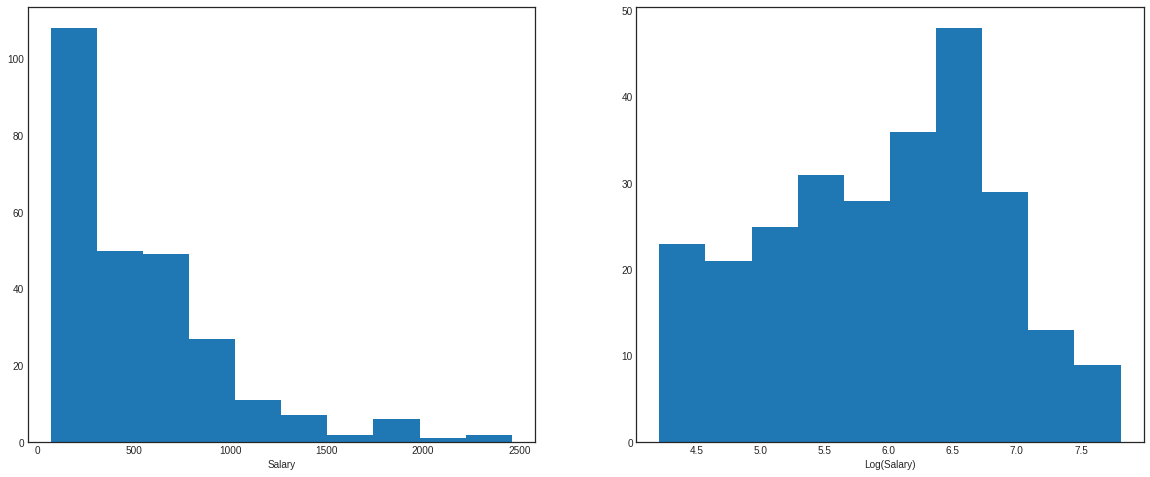

In [11]:
X = df[['Years', 'Hits']]
y = np.log(df.Salary)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.hist(df.Salary)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)')

In [13]:
tree_model = DecisionTreeRegressor(max_leaf_nodes=3)
tree_model.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

### Figure 8.1

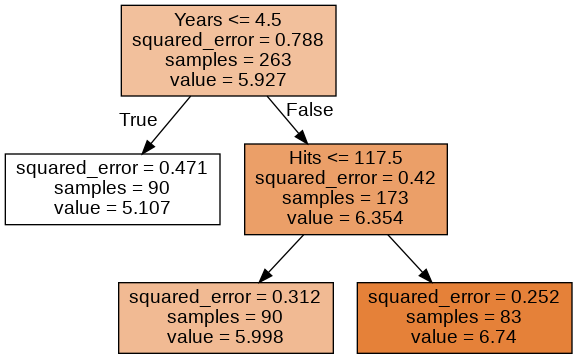

In [18]:
graph, = print_tree(tree_model, features=['Years', 'Hits'])
Image(graph.create_png())

###  Figure 8.2

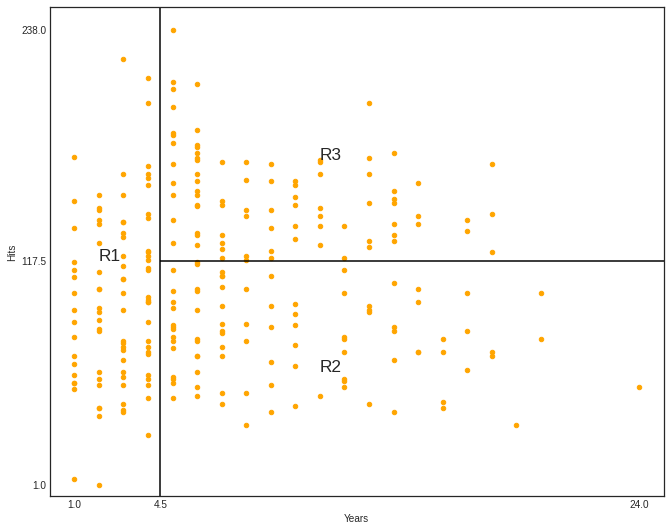

In [20]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(11,9))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

### Pruning
This is currently not supported in scikit-learn. See first point under 'disadvantages of decision trees in the <A href='http://scikit-learn.github.io/dev/modules/tree.html#'>documentation</A>. Implementation has been <A href='https://github.com/scikit-learn/scikit-learn/pull/941'>discussed</A> but Random Forests have better predictive qualities than a single pruned tree anyway if I understand correctly.
    

### 8.1.2 Classification Trees

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [21]:
url='https://raw.githubusercontent.com/rashida048/Datasets/master/Heart.csv'
df2 = pd.read_csv(url).drop('Unnamed: 0', axis=1).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


In [22]:
df2.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [23]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [24]:
df2.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,0,145,233,1,2,150,0,2.3,3,0.0,0,No
1,67,1,1,160,286,0,2,108,1,1.5,2,3.0,1,Yes
2,67,1,1,120,229,0,2,129,1,2.6,2,2.0,2,Yes
3,37,1,2,130,250,0,0,187,0,3.5,3,0.0,1,No
4,41,0,3,130,204,0,2,172,0,1.4,1,0.0,1,No


In [25]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [41]:
DT_classifier = DecisionTreeClassifier(max_depth=None, criterion='entropy',max_leaf_nodes=6, max_features=3, random_state=1)
DT_classifier.fit(X2,y2)

DecisionTreeClassifier(criterion='entropy', max_features=3, max_leaf_nodes=6,
                       random_state=1)

In [43]:
DT_classifier.score(X2,y2)

0.7474747474747475

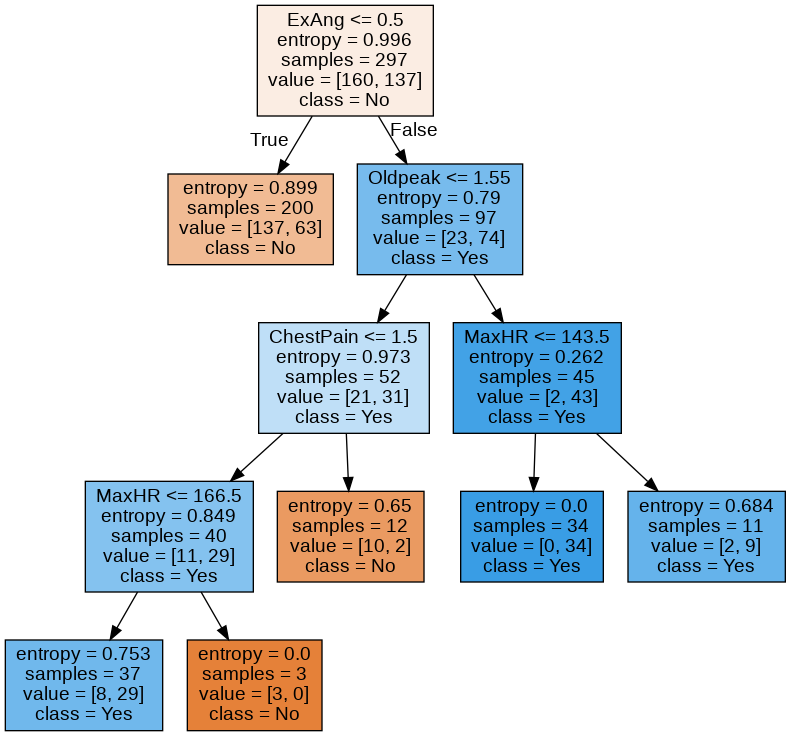

In [44]:
graph2, = print_tree(DT_classifier, features=X2.columns, class_names=['No', 'Yes'])
Image(graph2.create_png())

## Lab

### 8.3.1 Fitting Classification Trees

In R, I exported the dataset from package 'ISLR' to a csv file.

In [58]:
url='https://raw.githubusercontent.com/selva86/datasets/master/Carseats.csv'
df3 = pd.read_csv(url)
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [59]:
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]

df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [60]:
df3.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


In [93]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [94]:
classification_model = DecisionTreeClassifier(max_depth=4)
classification_model.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [95]:
print(classification_report(y, classification_model.predict(X)))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84       236
           1       0.89      0.56      0.69       164

    accuracy                           0.79       400
   macro avg       0.83      0.76      0.77       400
weighted avg       0.81      0.79      0.78       400



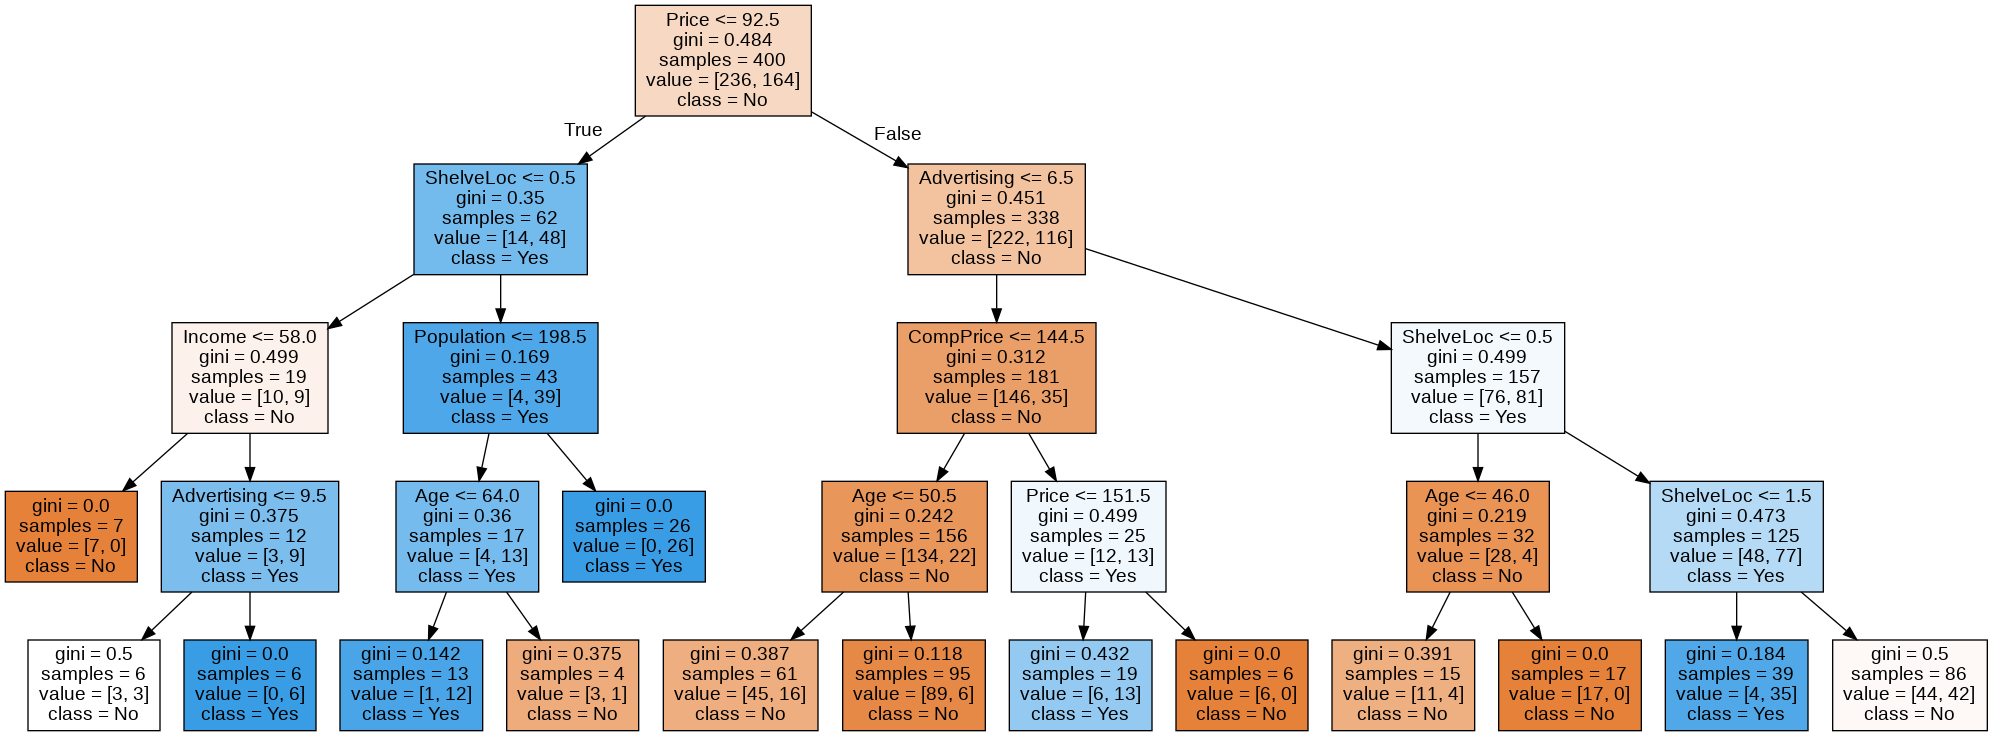

In [96]:
graph3, = print_tree(classification_model, features=X.columns, class_names=['No', 'Yes'])
Image(graph3.create_png())

In [97]:
classification_model.fit(X_train, y_train)
pred = classification_model.predict(X_test)

In [98]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True,No,Yes
Predicted,,
No,91,34
Yes,27,48


In [99]:
# Precision of the model using test data is 74%
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       118
           1       0.64      0.59      0.61        82

    accuracy                           0.69       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.69      0.69      0.69       200



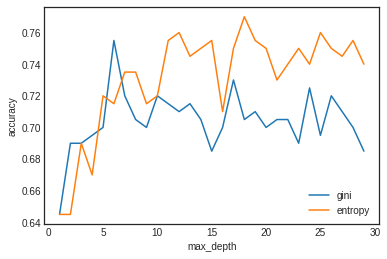

In [109]:
from sklearn.metrics import accuracy_score
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_gini.append(accuracy_score(y_test, pred))
 ####
 dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_entropy.append(accuracy_score(y_test, pred))
 ####
 max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

Pruning not implemented in scikit-learn.

### 8.3.2 Fitting Regression Trees

In R, I exported the dataset from package 'MASS' to a csv file.

In [110]:
url='https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/MASS/Boston.csv'
boston_df = pd.read_csv(url)
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   crim        506 non-null    float64
 2   zn          506 non-null    float64
 3   indus       506 non-null    float64
 4   chas        506 non-null    int64  
 5   nox         506 non-null    float64
 6   rm          506 non-null    float64
 7   age         506 non-null    float64
 8   dis         506 non-null    float64
 9   rad         506 non-null    int64  
 10  tax         506 non-null    int64  
 11  ptratio     506 non-null    float64
 12  black       506 non-null    float64
 13  lstat       506 non-null    float64
 14  medv        506 non-null    float64
dtypes: float64(11), int64(4)
memory usage: 59.4 KB


In [112]:
y = boston_df.medv
X = boston_df.drop('medv', axis=1).drop('Unnamed: 0', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [113]:
# Pruning not supported. Choosing max depth 3)
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)

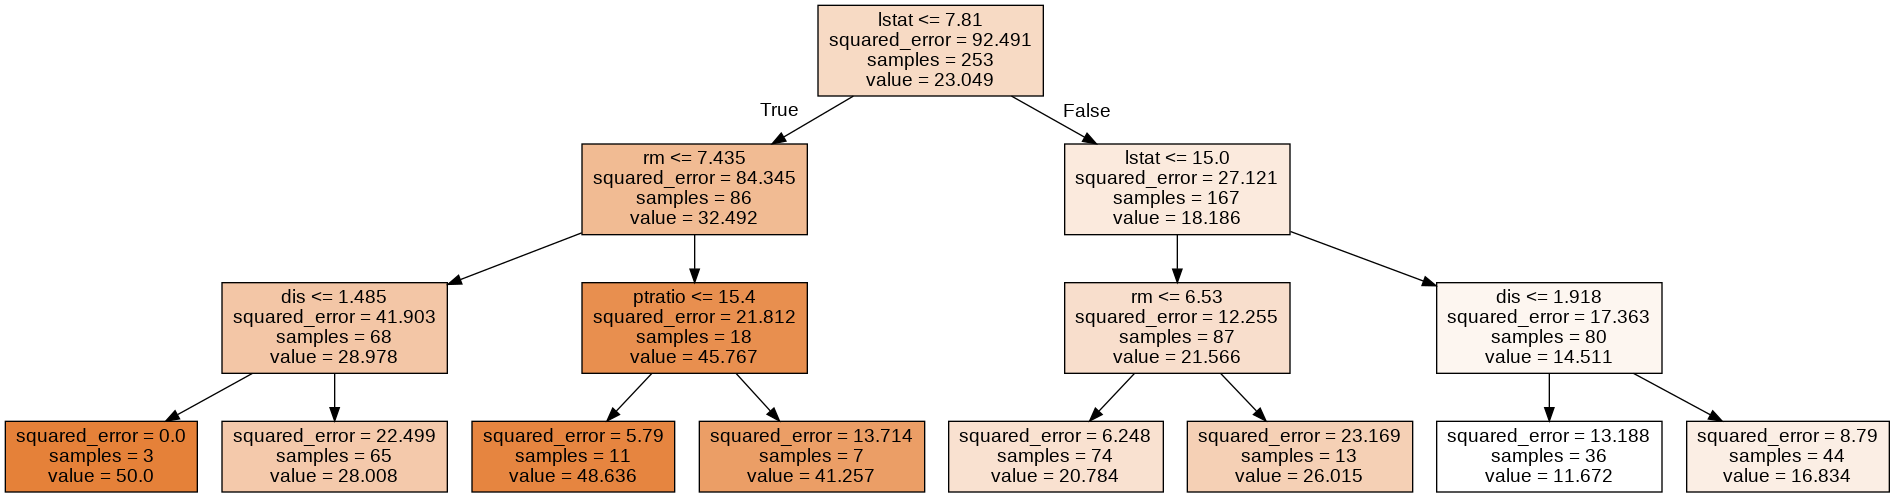

In [114]:
graph, = print_tree(regr2, features=X.columns)
Image(graph.create_png())

Text(0, 0.5, 'y_test')

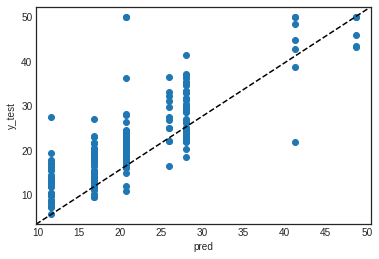

In [115]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [116]:
mean_squared_error(y_test, pred)

26.02323085009745

### 8.3.3 Bagging and Random Forests

In [117]:
# There are 13 features in the dataset
X.shape

(506, 13)

In [131]:
# Bagging: using all features
rf = RandomForestRegressor(max_features='sqrt', random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=1)

Text(0, 0.5, 'y_test')

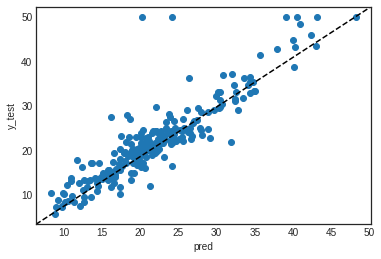

In [134]:
pred = rf.predict(X_test)
#pred_prob=rf.predict_proba(test)[:, 1]

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [130]:
mean_squared_error(y_test, pred)

15.38572678260869

In [155]:
# Random forests: using 6 features
regr2 = RandomForestRegressor( random_state=1)
regr2.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [156]:
pred = regr2.predict(X_test)
mean_squared_error(y_test, pred)

16.17512869960475

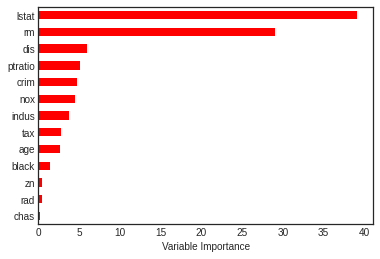

In [137]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

We will try adjusting the following set of hyperparameters:
* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

## Random Hyperparameter Grid
To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:

In [151]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 325, 550, 775, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4], 'bootstrap': [True, False]}


On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [152]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 325, 550, 775,
                                                         1000]},
                   random_state=42, verbose=2)

In [153]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [154]:
best_random = rf_random.best_estimator_
#grid_accuracy = evaluate(best_grid, X_test, y_test)
pred = best_random.predict(X_test)
mean_squared_error(y_test, pred)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

16.75023853515958

## Grid Search with Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [157]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [6,8,12],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2,4, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 500, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [158]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': False,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [159]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=8, max_features='sqrt',
                      min_samples_leaf=2, n_estimators=500)

### Best RF model

In [160]:
best_grid = grid_search.best_estimator_
pred = best_grid.predict(X_test)
mean_squared_error(y_test, pred)


16.899060161128673

### 8.3.4 Boosting

In [124]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=1)

zn          0.013059
chas        0.121257
rad         0.153199
black       0.460309
indus       0.576559
nox         0.731767
age         0.922677
tax         1.098078
crim        2.799589
ptratio     4.370389
dis         5.896297
rm         27.934202
lstat      54.922618
dtype: float64


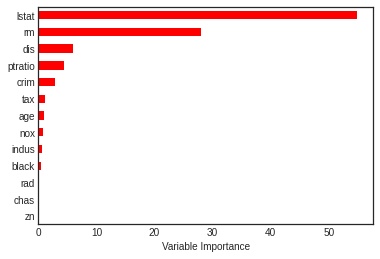

In [125]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [127]:
mean_squared_error(y_test, regr.predict(X_test))

15.592155779633027